In [61]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)



### STUDY EVENT

select a particular file, look at the events in all fashions allowed by the file


#### MC

Contains 6 tables:

In [35]:
!ptdump example_files/sophronia_27_208Tl.h5:/MC/

/MC/ (Group) ''
/MC//configuration (Table(30,)shuffle, zlib(4)) ''
/MC//event_mapping (Table(316,)shuffle, zlib(4)) ''
/MC//hits (Table(116760,)shuffle, zlib(4)) ''
/MC//particles (Table(26089,)shuffle, zlib(4)) ''
/MC//sns_positions (Table(0,)shuffle, zlib(4)) ''
/MC//sns_response (Table(0,)shuffle, zlib(4)) ''


I dont really care about sns stuff, configuration is interesting, but really we care about hits and particles

In [97]:
# provide file_path here
file_path = 'example_files/sophronia_27_208Tl.h5'

# read in
df = pd.read_hdf(file_path, 'MC/particles')
events = np.unique(df.event_id.to_numpy())

print("{} events\nRange: {} - {}\nMC events are even and odd, unlike other events.".format(len(events), np.min(events), np.max(events)))

316 events
Range: 260000 - 260320
MC events are even and odd, unlike other events.


**Select event**

In [98]:
evt = events[230]
print("Selected event: {} ({})".format(evt, evt*2))

Selected event: 260235 (520470)


**Load particle information**

Gives full information about particle interactions related to a Tl208 decay

In [99]:
# done already to determine number of events
print(df.columns.to_numpy())
df_ps = df[df.event_id == evt]
display(df_ps)

['event_id' 'particle_id' 'particle_name' 'primary' 'mother_id'
 'initial_x' 'initial_y' 'initial_z' 'initial_t' 'final_x' 'final_y'
 'final_z' 'final_t' 'initial_volume' 'final_volume' 'initial_momentum_x'
 'initial_momentum_y' 'initial_momentum_z' 'final_momentum_x'
 'final_momentum_y' 'final_momentum_z' 'kin_energy' 'length'
 'creator_proc' 'final_proc']


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
19148,260235,1,Tl208,True,0,396.316498,392.882629,532.762024,0.000000,396.316498,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,none,RadioactiveDecay
19149,260235,4,e-,False,1,396.316498,392.882629,532.762024,0.000031,396.267212,...,-0.271762,-0.274318,0.311141,0.000000,-0.000000,-0.000000,2.010639e-01,1.570741e-01,RadioactiveDecay,eIoni
19150,260235,3,anti_nu_e,False,1,396.316498,392.882629,532.762024,0.000031,12500.000000,...,1.190055,-0.239224,1.042522,1.190055,-0.239224,1.042522,1.600098e+00,1.627410e+04,RadioactiveDecay,Transportation
19151,260235,2,Pb208[3197.711],False,1,396.316498,392.882629,532.762024,0.000031,396.316498,...,-0.918293,0.513541,-1.353663,-0.000000,0.000000,-0.000000,7.587834e-06,0.000000e+00,RadioactiveDecay,RadioactiveDecay
19152,260235,6,gamma,False,2,396.316498,392.882629,532.762024,0.000031,81.852943,...,-0.470660,0.096344,0.330614,0.000000,-0.000000,-0.000000,5.831881e-01,1.425930e+03,RadioactiveDecay,phot
19153,260235,28,e-,False,6,81.852943,-526.522278,1477.692383,4.756423,81.852943,...,-0.005539,0.001385,-0.005163,-0.000000,0.000000,-0.000000,5.797000e-05,1.447787e-07,phot,msc
19154,260235,27,e-,False,6,81.852943,-526.522278,1477.692383,4.756423,81.852943,...,-0.004363,0.001441,0.006390,-0.000000,-0.000000,0.000000,6.061000e-05,1.473075e-07,phot,msc
19155,260235,26,e-,False,6,81.852943,-526.522278,1477.692383,4.756423,81.852943,...,-0.005164,0.020289,-0.019496,-0.000000,-0.000000,0.000000,8.001700e-04,1.444178e-05,phot,eIoni
19156,260235,25,e-,False,6,81.852943,-526.522278,1477.692383,4.756423,81.852943,...,0.015393,0.007710,-0.025348,0.000000,-0.000000,-0.000000,9.178900e-04,1.584320e-05,phot,eIoni
19157,260235,24,e-,False,6,81.852943,-526.522278,1477.692383,4.756423,81.852943,...,0.010349,0.001023,0.003497,-0.000000,0.000000,-0.000000,1.177700e-04,3.094144e-06,phot,eIoni


**Load hits**

,event_id,particle_id,hit_id,x,y,z,time,energy,label
87645,260235,33,0,1.903661,63.397884,887.703247,2.249825,0.000021,ACTIVE
87646,260235,32,0,2.495320,62.597496,887.799744,2.086922,0.002596,ACTIVE
87647,260235,32,1,3.055303,61.781494,887.830383,2.090396,0.002120,ACTIVE
87648,260235,32,2,3.585819,60.945576,887.819763,2.093871,0.000996,ACTIVE
87649,260235,32,3,4.041701,60.066914,887.799133,2.097346,0.001261,ACTIVE
...,...,...,...,...,...,...,...,...,...
88330,260235,85,9,-0.340700,59.624142,890.745789,2.111066,0.000794,ACTIVE
88331,260235,85,10,-0.347312,59.618935,890.743591,2.111278,0.000862,ACTIVE
88332,260235,85,11,-0.342924,59.623440,890.741516,2.111454,0.001830,ACTIVE
88333,260235,85,12,-0.343436,59.624454,890.744141,2.111558,0.002050,ACTIVE


/tmp/ipykernel_9614/3328195376.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)


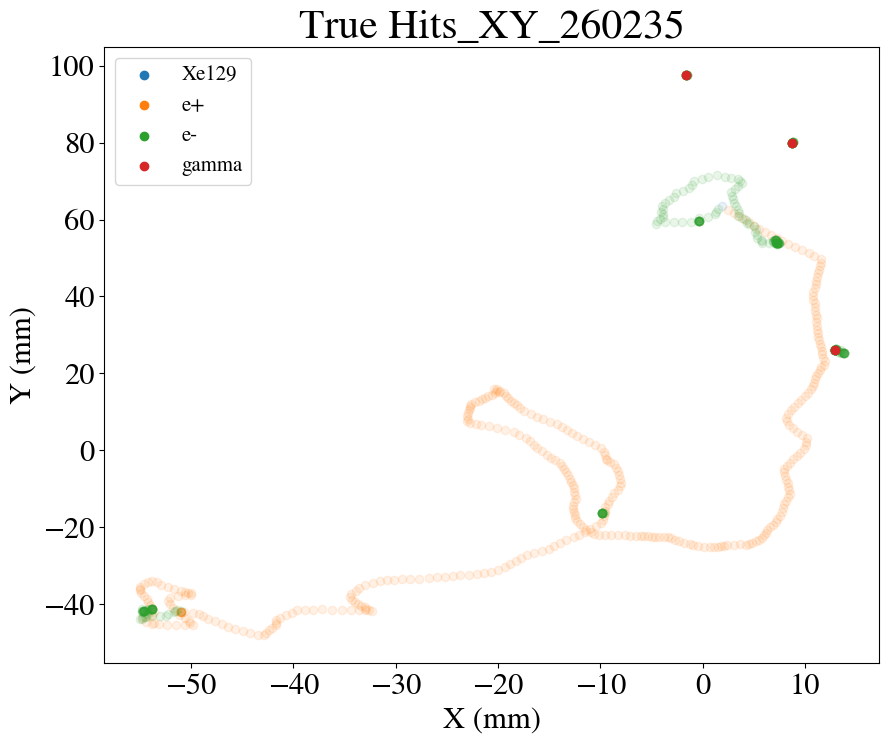

In [102]:
true_info = mcio.load_mchits_df(file_path).reset_index()

this_evt_true_info = true_info[true_info.event_id == evt]

display(this_evt_true_info)

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

######## PLOTTING

def return_id(number):
    return str(df_ps[df_ps.particle_id == number].particle_name.values).strip("'[]'")

this_evt_true_info['particle_name'] = this_evt_true_info['particle_id'].apply(return_id)

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

for pid, df in this_evt_true_info.groupby('particle_name'):

    xt = df.x
    yt = df.y
    zt = df.z
    et = df.energy*1000

   
    if (pid == 'gamma') or (pid == 'Xe131'):
        plt.scatter(xt, yt,  alpha=1, label = str(pid))
    else:
        plt.scatter(xt, yt,  alpha=0.1, label = str(pid))

    
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');

# Retrieve legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a single legend for all subplots
legend = plt.legend(handles, labels, fontsize=15)
for handle in legend.legendHandles:
    handle.set_alpha(1.0)

plt.title('True Hits_XY_' + str(evt), fontsize=30)
plt.show()

#### SOPHRONIA

#### BEERSHEBA

#### ISAURA